In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import dipy.data as dpd
import dipy.core.sphere as dps 
import dipy.sims as sims
import dipy.core.gradients as grad
import dipy.core.geometry as geo
import nibabel as nib

import scm.utils as ut
import scm.scm as scm

In [2]:
# 65 direction DTI data
fdata, fbval, fbvec = dpd.get_data()
gtab = grad.gradient_table(fbval, fbvec)
gtab.bvals = gtab.bvals # Make the units work out
data_ni = nib.load(fdata)
data = data_ni.get_data()

In [3]:
ni, gtab = dpd.read_stanford_hardi()

In [4]:
data = ni.get_data()

In [5]:
n_split = 75

In [6]:
data_train = np.concatenate([data[..., :5], data[..., 10:85]], -1)
data_test = np.concatenate([data[..., 5:10], data[..., 85:]], -1)

In [7]:
data_train.shape, data_test.shape

((81, 106, 76, 80), (81, 106, 76, 80))

In [8]:
gtab_train = grad.gradient_table_from_bvals_bvecs(np.concatenate([gtab.bvals[:5], gtab.bvals[10:85]]), 
                                                  np.concatenate([gtab.bvecs[:5], gtab.bvecs[10:85]]))

gtab_test = grad.gradient_table_from_bvals_bvecs(np.concatenate([gtab.bvals[5:10], gtab.bvals[85:]]), 
                                                 np.concatenate([gtab.bvecs[5:10], gtab.bvecs[85:]]))


In [9]:
sph1 = dpd.get_sphere()
#sph1 = dps.Sphere(xyz=[[1,0,0], [0,1,0], [0,0,1]])

In [10]:
dm_train = ut.design_matrix(gtab_train, sph1)

In [11]:
len(dm_train)

2025

In [12]:
alpha = 0.0001
l1_ratio = 0.8

In [26]:
reload(ut)

<module 'scm.utils' from '/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/scm/utils.py'>

In [27]:
dist_weights = ut.signal_weights(gtab) 
pp_sig = ut.preprocess_signal(data_train, gtab_train, 40, 40, 40, dist_weights=dist_weights)
sq_weights = dist_weights**2

In [28]:
pp_sig

array([  8.66641763e-03,  -2.30855435e-02,  -8.28539410e-02, ...,
         1.76294142e-05,  -1.54497775e-03,  -1.90557941e-03])

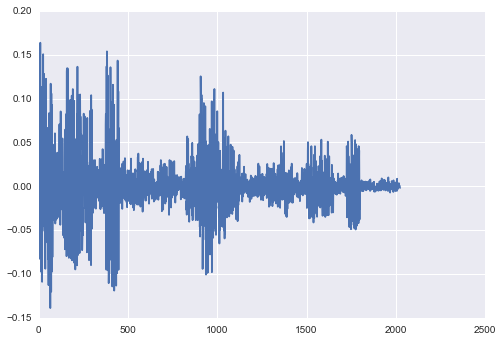

In [30]:
plt.plot(pp_sig)

In [33]:
new_dm = dm_train
new_sig = pp_sig

In [34]:
X = new_dm[:n_split]
X_prime = new_dm[n_split:n_split*2]

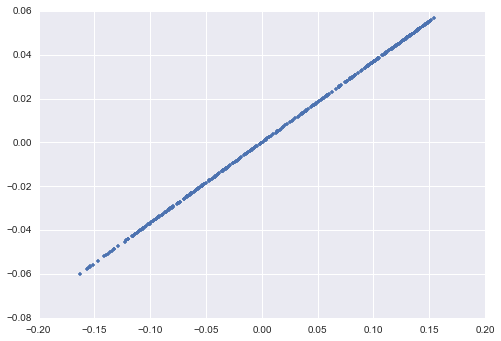

In [35]:
plt.plot(X[0], X_prime[0], '.')

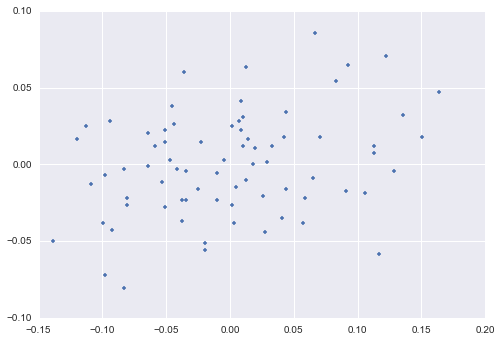

In [36]:
plt.plot(new_sig[:n_split], new_sig[n_split:n_split*2], '.')

In [37]:
from sklearn.linear_model import ElasticNet

In [38]:
this_alpha = alpha * np.sum(sq_weights)/new_dm.shape[0]
EN = ElasticNet(alpha=this_alpha, l1_ratio=l1_ratio, positive=True)
beta = EN.fit(new_dm, new_sig).coef_
#beta, rnorm = opt.nnls(new_dm, new_sig)

In [39]:
new_dm.shape, new_sig.shape

((2025, 362), (2025,))

In [40]:
y_hat = np.dot(new_dm, beta)

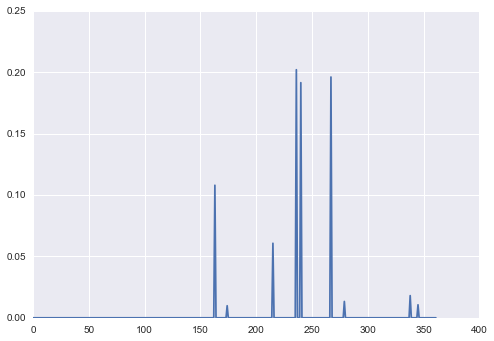

In [41]:
plt.plot(beta)

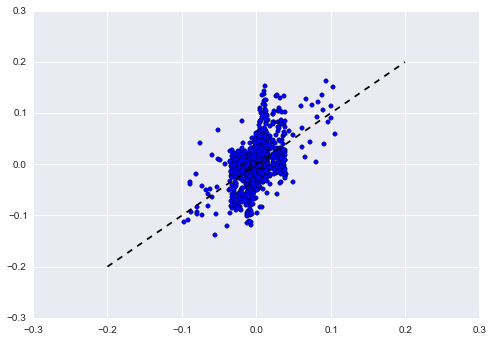

In [42]:
plt.scatter(y_hat, new_sig)
plt.plot([-0.2, 0.2], [-0.2, 0.2], 'k--')

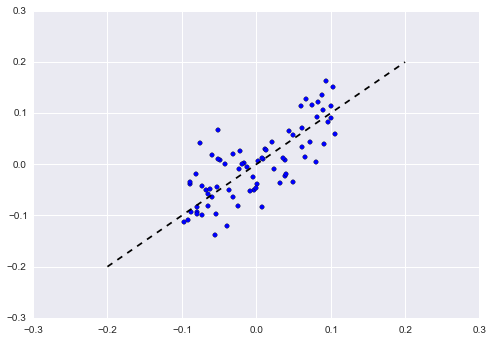

In [43]:
plt.scatter(y_hat[:n_split], new_sig[:n_split])
plt.plot([-0.2, 0.2], [-0.2, 0.2], 'k--')

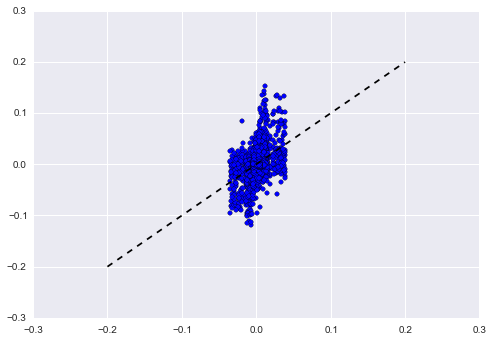

In [44]:
plt.scatter(y_hat[n_split:], new_sig[n_split:])
plt.plot([-0.2, 0.2], [-0.2, 0.2], 'k--')

In [45]:
#beta_non, rnorm = opt.nnls(new_dm[:n_split], new_sig[:n_split])
#beta_non, rnorm = opt.nnls(new_dm[:n_split], new_sig[:n_split])
EN = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, positive=True)
beta_non = EN.fit(new_dm[:n_split], new_sig[:n_split]).coef_


/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:490: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [46]:
y_hat_non = np.dot(new_dm, beta_non)

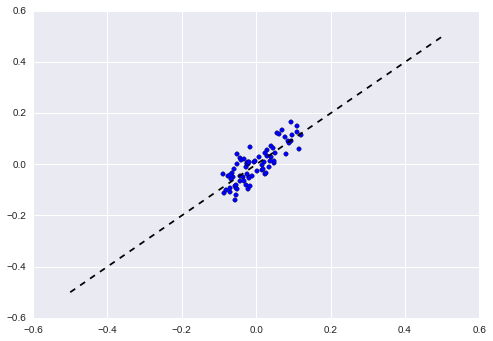

In [47]:
plt.scatter(y_hat_non[:n_split], new_sig[:n_split])
plt.plot([-0.5, 0.5], [-0.5, 0.5], 'k--')

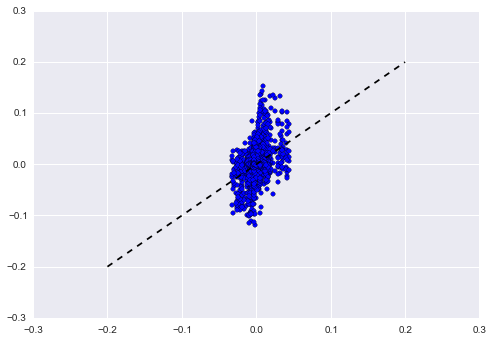

In [48]:
plt.scatter(y_hat_non[n_split:], new_sig[n_split:])
plt.plot([-0.2, 0.2], [-0.2, 0.2], 'k--')

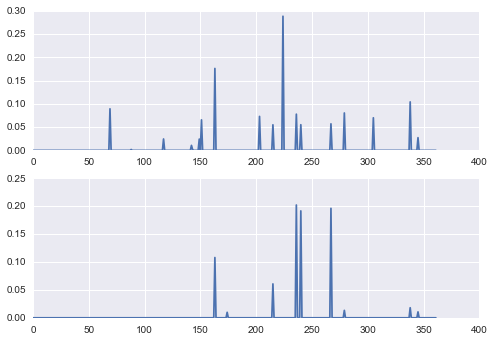

In [49]:
fig, ax = plt.subplots(2)
ax[0].plot(beta_non)
ax[1].plot(beta)

In [50]:
import dipy.viz.projections as proj
reload(proj)

<module 'dipy.viz.projections' from '/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/dipy/viz/projections.pyc'>

In [51]:
%matplotlib inline

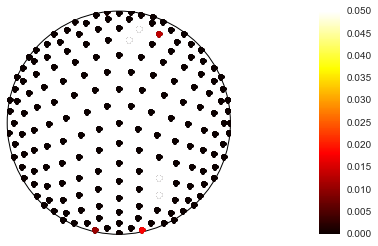

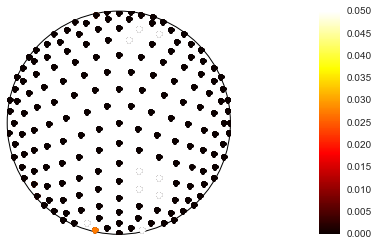

In [52]:
proj.sph_project(sph1.vertices.T, beta, vmax=0.05) 
proj.sph_project(sph1.vertices.T, beta_non, vmax=0.05) 


In [53]:
np.dot(beta_non, beta_non), np.dot(beta, beta)

(0.171575751397297, 0.13204458315436224)

In [54]:
(np.sqrt(np.mean( (y_hat_non[:n_split]- new_sig[:n_split]) ** 2))/
np.sqrt(np.mean( (new_sig[:n_split] - y_hat[:n_split])**2 ) ))

0.88875131999692292

In [58]:
dm_test = ut.design_matrix(gtab_test, sph1)

In [59]:
y_hat_test = np.dot(dm_test, beta)
y_hat_non_test = np.dot(dm_test, beta_non)

In [64]:
dist_weights = ut.signal_weights(gtab_test) 
sig_test = ut.preprocess_signal(data_test, gtab_test, 40, 40, 40, dist_weights=dist_weights)
sq_weights = dist_weights**2

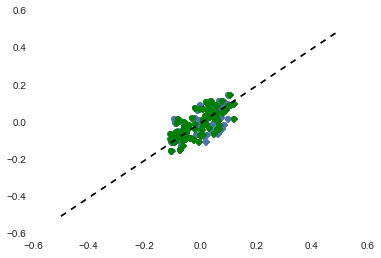

In [65]:
plt.plot(y_hat_test[:n_split], sig_test[:n_split], 'o')
plt.plot(y_hat_non_test[:n_split], sig_test[:n_split], 'go')
plt.plot([-0.5, 0.5], [-0.5, 0.5], 'k--')

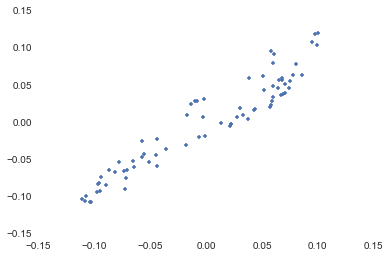

In [66]:
plt.plot(y_hat_test[:n_split], y_hat_non_test[:n_split], '.')

In [67]:
(np.sqrt(np.mean( (y_hat_non_test[:n_split]- sig_test[:n_split]) ** 2))/
np.sqrt(np.mean((sig_test[:n_split] - y_hat_test[:n_split])**2 )))

0.95032765612896286

In [68]:
import dipy.viz.fvtk as fvtk

In [44]:
def plot_peaks(beta, sphere, fname=None):
    idx = np.where(beta>0)
    peak_dirs = sphere.vertices[idx]
    peak_values = beta[idx]
    ren = fvtk.ren()
    beta_peaks = fvtk.peaks(peak_dirs, peak_values)
    fvtk.add(ren, beta_peaks)
    if fname is None:
        fvtk.show(ren)
    else:
        fvtk.record(ren, out_path=fname) 

In [45]:
#plot_peaks(beta, sph1, fname='./fig.png')
#!open fig.png